<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/transfer_learning_tensor_flow_3_scalling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning wth tensro flow: Scalling up (🍔 👁 Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the originla Food1010 paper with 10% of the trainig (leveraging the power of deep learning).

Original food101 paper: [food 101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)

Our baseline to beat is 50.76% across 101 classes.

In [3]:
import os
import tensorflow as tf

In [4]:
# Check if we're using a GPU

!nvidia-smi

Sun May 26 14:51:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In previous notebooks we created a series of helper functions to do different tasks, let's download them.

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-26 14:51:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-26 14:51:06 (119 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
from helper_functions import create_tensorboard_callback, \
 plot_loss_curves, \
 compare_historys, \
 unzip_data, \
 walk_through_dir

In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2024-05-26 14:51:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  38.4MB/s    in 42s     

2024-05-26 14:51:52 (37.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [8]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101

In [9]:
# Setups data inputs
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE
                                                                            )

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False # don't shuffle test data for prediction analysis
                                                                )

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a ig dog model wih transfer learnig on 10% of 101 food classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build augmentation right in the model
* Build a headless (no top layers) Functional EfficentNetV2B0 backbonded-model (We'll create or own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validation on 15% of the test dta, to save epoch time)
                                                                                

In [10]:
# Create checkpoint callback
checkpoint_path = "101_food_classes_10_percent_checkpoints_efficientnetv2b0_feature_extract"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          monitor="val_accuracy",
                                                          save_best_only=True,
                                                          save_freq="epoch",
                                                          verbose=1)

In [11]:
# Create data augmentation layer to incorporate it right into the model

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet
], name="data_augmentation")

In [12]:
# set the base and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

24274472/24274472 [==============================] - 1s 0us/step


In [13]:
# Setup model archtecture with trainable top layer
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happes during trainig phase)
x = base_model(x, training=False) # put the base mdoel in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # pool outputs
outputs = layers.Dense(len(train_data_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 101)               129381

In [15]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [16]:
model_all_classes_10_percent = model.fit(train_data_10_percent,
                          epochs=5, # fit for 5 epochs
                          steps_per_epoch=len(train_data_10_percent),
                          validation_data=test_data,
                          validation_steps=int(0.15 * len(test_data)), # validate for 15% of the test data
                          callbacks=[checkpoint_callback])


Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.5357 - accuracy: 0.2368
Epoch 1: val_accuracy improved from -inf to 0.41711, saving model to 101_food_classes_10_percent_checkpoints_efficientnetv2b0_feature_extract
237/237 [==============================] - 192s 768ms/step - loss: 3.5357 - accuracy: 0.2368 - val_loss: 2.7020 - val_accuracy: 0.4171
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.4156 - accuracy: 0.4490
Epoch 2: val_accuracy improved from 0.41711 to 0.48941, saving model to 101_food_classes_10_percent_checkpoints_efficientnetv2b0_feature_extract
237/237 [==============================] - 114s 480ms/step - loss: 2.4156 - accuracy: 0.4490 - val_loss: 2.1730 - val_accuracy: 0.4894
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 2.0437 - accuracy: 0.5139
Epoch 3: val_accuracy improved from 0.48941 to 0.49497, saving model to 101_food_classes_10_percent_checkpoints_efficientnetv2b0_feature_extract
237/237 [====

In [50]:
 # Evaluate on the whole test dataset

 model.evaluate(test_data)

790/790 [==============================] - 48s 61ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

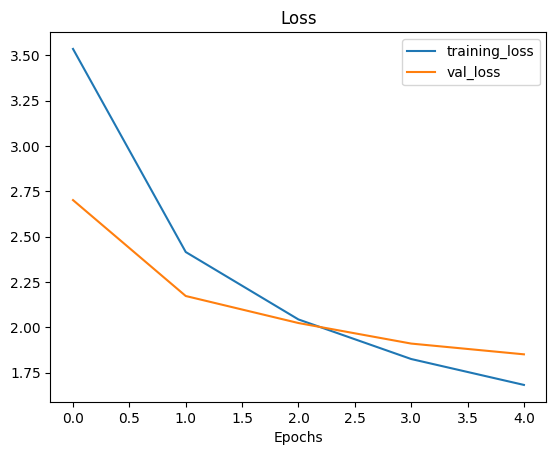

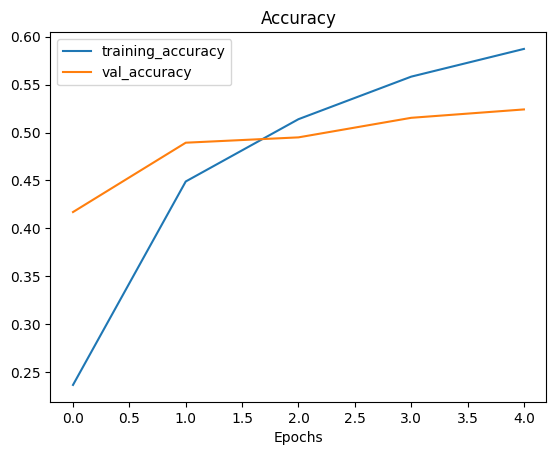

In [51]:
plot_loss_curves(model_all_classes_10_percent)

> ❓ **Question:**  What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing to well on the training data and not generalizing to unseen data)

## Fine-tuning

In [52]:
# Unfreeze all of the layers in the base mdoel

base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [53]:
# Recompile model with lower learnig rate (it's a typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [54]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_22 True
sequential_4 True
efficientnetb0 True
global_average_pooling2d_9 True
dense_8 True


In [55]:
#Check which layers are tarinable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_21 True
1 rescaling_9 True
2 normalization_4 True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block2a_expand_conv True
18 block2a_expand_bn True
19 block2a_expand_activation True
20 block2a_dwconv_pad True
21 block2a_dwconv True
22 block2a_bn True
23 block2a_activation True
24 block2a_se_squeeze True
25 block2a_se_reshape True
26 block2a_se_reduce True
27 block2a_se_expand True
28 block2a_se_excite True
29 block2a_project_conv True
30 block2a_project_bn True
31 block2b_expand_conv True
32 block2b_expand_bn True
33 block2b_expand_activation True
34 block2b_dwconv True
35 block2b_bn True
36 block2b_activation True
37 block2b_se_squeeze True
38 block2b_se_reshape True
39 block2b_se_reduce True
40 

In [56]:
# fine-tune for more 5 epochs
fine_tune_epochs = 10

# Fine-tune ou model

history_all_classes_10_percent_fine_tune = model.fit(
    train_data_10_percent,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    initial_epoch=model_all_classes_10_percent.epoch[-1],
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 5/10
237/237 [==============================] - ETA: 0s - loss: 0.3231 - accuracy: 0.9026
Epoch 5: val_accuracy improved from 0.53628 to 0.54767, saving model to 101_food_classes_10_percent_checkpoints_efficientnetv2b0_feature_extract
237/237 [==============================] - 447s 2s/step - loss: 0.3231 - accuracy: 0.9026 - val_loss: 2.1808 - val_accuracy: 0.5477
Epoch 6/10
237/237 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9299
Epoch 6: val_accuracy did not improve from 0.54767
237/237 [==============================] - 295s 1s/step - loss: 0.2263 - accuracy: 0.9299 - val_loss: 2.3275 - val_accuracy: 0.5371
Epoch 7/10
237/237 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 0.9514
Epoch 7: val_accuracy improved from 0.54767 to 0.56144, saving model to 101_food_classes_10_percent_checkpoints_efficientnetv2b0_feature_extract
237/237 [==============================] - 264s 1s/step - loss: 0.1602 - accuracy: 0.9514 - val_loss: 2.354

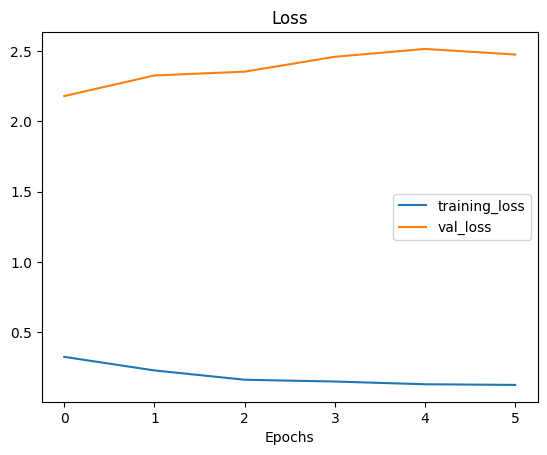

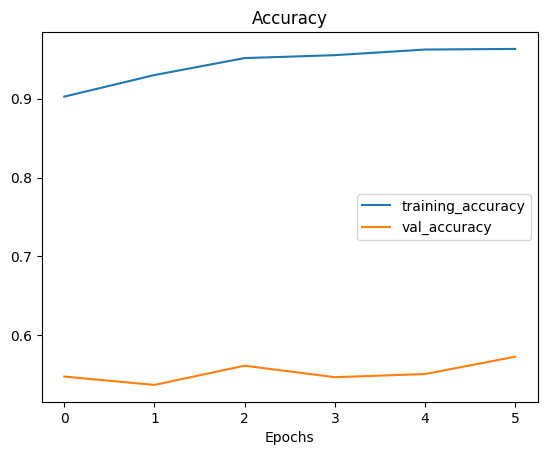

In [57]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

In [60]:
feature_extraction_results = model.evaluate(test_data)

feature_extraction_results

790/790 [==============================] - 50s 63ms/step - loss: 2.2115 - accuracy: 0.6004


[2.2114789485931396, 0.6003564596176147]

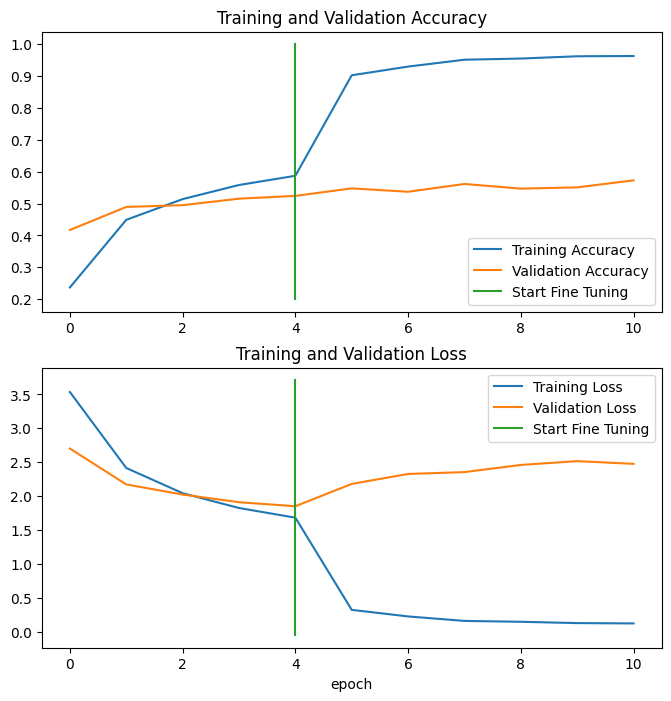

In [59]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(model_all_classes_10_percent, history_all_classes_10_percent_fine_tune)

## Saving and load or model

To use our model in a external application, we'll need to save it and export it somewhere

In [61]:
# Save our fine-tuning model

model.save("drive/MyDrive/tensor_flow_course/101_food_classes_10_percent_fine_tune_saved_big_dog_model")

In [62]:
# Load and evaluate saved model
loaded_saved_model = tf.keras.models.load_model("drive/MyDrive/tensor_flow_course/101_food_classes_10_percent_fine_tune_saved_big_dog_model")

In [63]:
# Evaluate the loaded model and compare performance to pre-saved mdoel
loaded_model_results = loaded_saved_model.evaluate(test_data)

loaded_model_results

790/790 [==============================] - 51s 63ms/step - loss: 2.2115 - accuracy: 0.6004


[2.2114789485931396, 0.6003564596176147]

## Evaluating the performance of the big dog model across alldifferent class

Let's make some predictions, visualize them and then later find outwhich prediciont were the "most" wrong.

In [64]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-05-26 15:49:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

06_101_food_class_1 100%[===================>]  44.59M  25.6MB/s    in 1.7s    

2024-05-26 15:49:14 (25.6 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



In [65]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [66]:
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [67]:
# Evaluate loaded mdoel (the one we just downloas on test data)

results_loaded_model = model.evaluate(test_data)

results_loaded_model

790/790 [==============================] - 50s 62ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

[F1 score](https://en.wikipedia.org/wiki/F-score)
[Calculate precision and recall](https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/)
[Calculate accuracy](https://www.omnicalculator.com/statistics/accuracy)

## Making prediciton with our trained model

In [76]:
# Make predicitons with model

pred_probs = model.predict(test_data)

790/790 [==============================] - 46s 58ms/step


In [77]:
len(test_data)

790

In [78]:
len(pred_probs)

25250

In [71]:
pred_probs.shape

(25250, 101)

In [79]:
pred_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [80]:
pred_probs[0]

array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
       8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
       1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
       2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
       6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
       1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
       8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
       2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
       1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
       1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
       8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
       2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
       3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
       8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.74041920e-05,
      

In [81]:
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
        8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
        1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
        2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
        6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
        1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
        8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
        2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
        1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
        1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
        8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
        2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
        3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
        8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.740419

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [82]:
# We get one prediction probability per class (in our case there's 101 prediciton probabilities)

print(f"Number of predicitons probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediciton probability sample 0 looks like: \n {pred_probs[0]}")
print(f"The class with the higest prediciton probability by the model sample 0: {pred_probs[0].argmax()}")

Number of predicitons probabilities for sample 0: 101
What prediciton probability sample 0 looks like: 
 [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.73150862

In [83]:
# Getg the pred clases for each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [84]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've goa a predcition array of all our model's predicitons, to evaluyate them, we need to compare them to the labbels.

In [85]:
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, ..., 0, 0] we want the index value where the "1" occurs

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [86]:
# How many y_labels are there?

len(y_labels)

25250

## Evaluatin our model's predictions

One way to check that our model's predictions is in the smae order as our test labels arrays is to fin the accuracy score.

In [87]:
results_donwloaded_model = model.evaluate(test_data)

790/790 [==============================] - 49s 62ms/step - loss: 1.8027 - accuracy: 0.6078


In [88]:
# Let's try scikit-learn's accuracy score function and see aht comes up with

from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_labels, pred_classes)

sklearn_accuracy

0.6077623762376237

In [47]:
# Does the metrics come close to our model's evalute results

import numpy as np

np.isclose(results_donwloaded_model[1], sklearn_accuracy)

True

In [89]:
from helper_functions import make_confusion_matrix

class_names = train_data_10_percent.class_names

make_confusion_matrix(y_labels, pred_classes, class_names, (100, 100), 20)

## Let's keep the evaluation train going, time for aclassification report

Scikit-learn's has a helpful function for acquiring many diferent classification metricsper class (e.g precision, recall, f1-score)

In [90]:
from sklearn.metrics import classification_report

print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The number abov give a great class-by-class evaluation of our model's predicitons but with so many classes, they're quite hard to understand.

How about we create visualization to get a better undertading?

In [91]:
# Get a dictonary of the classification report

classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [92]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

Let's plot all of our classes F1-scores

In [93]:
# Create empty dictionary

class_f1_scores = {}

# Loop through the classification report dictionary items
for key, value in classification_report_dict.items():
  if key == "accuracy": # stop once we get accuracy key
    break
  else:
    # Add class names and f1-score to ne dictionary
    class_f1_scores[class_names[int(key)]] = value["f1-score"]


class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [97]:
# Turn f1-score into dtaframe for visualization
import pandas as pd

class_f1_scores_df = pd.DataFrame({
    "class": list(class_f1_scores.keys()),
    "f1-score": list(class_f1_scores.values())
}).sort_values("f1-score", ascending=False)

class_f1_scores_df

,class,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


<Axes: ylabel='class'>

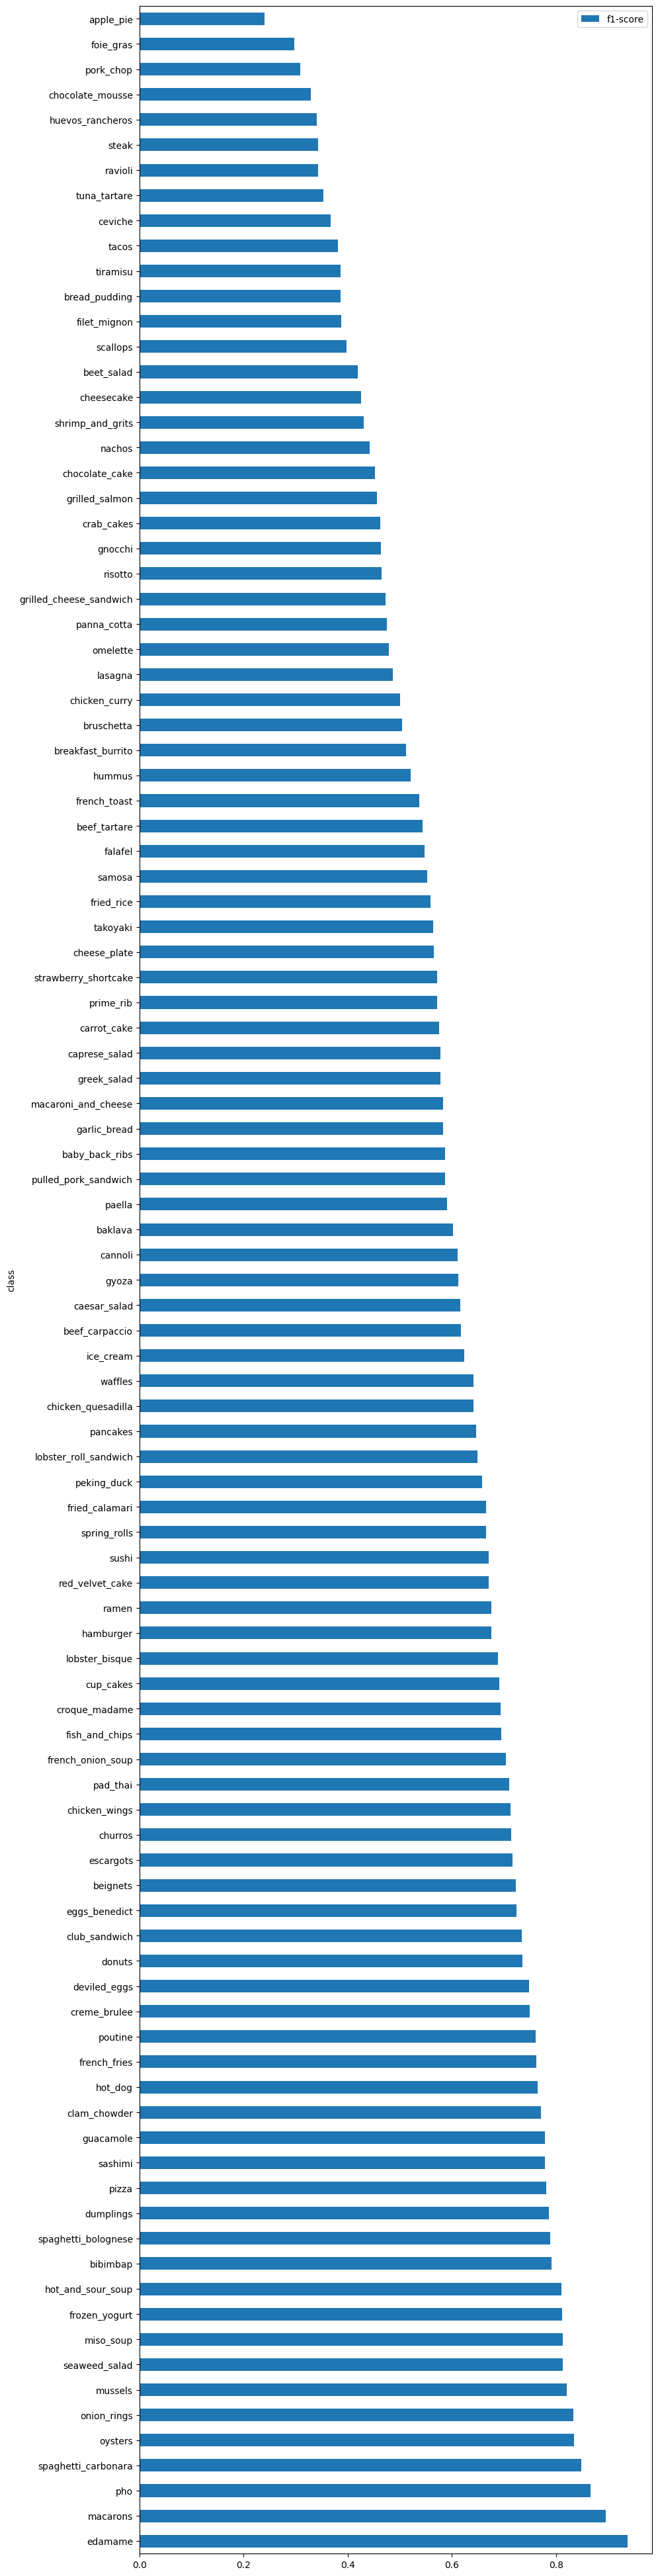

In [100]:
class_f1_scores_df.plot(x="class", y="f1-score", kind="barh", figsize=(10, 50))

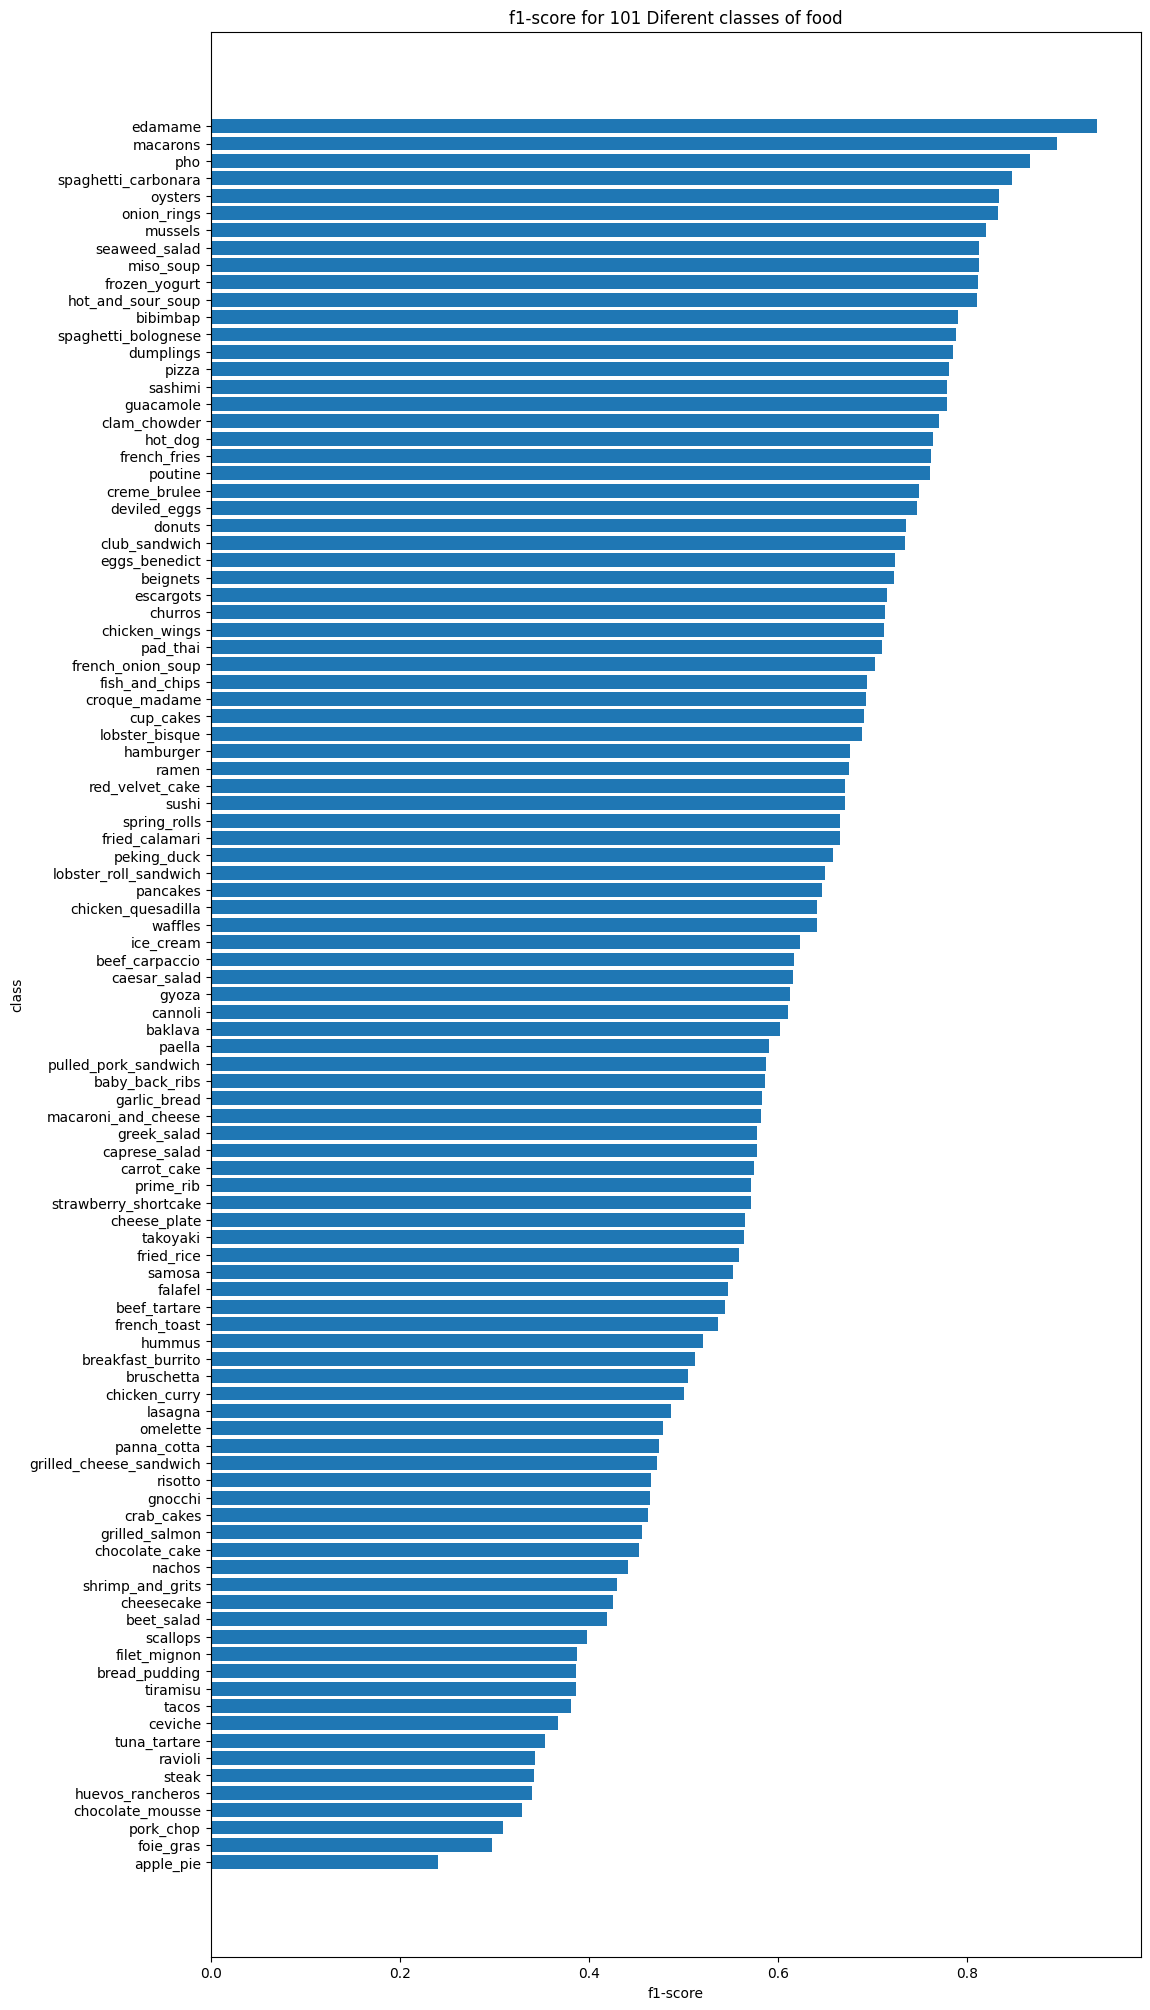

In [105]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))

scores = ax.barh(class_f1_scores_df["class"], class_f1_scores_df["f1-score"])

ax.set_yticks(class_f1_scores_df["class"])
ax.set_yticklabels(class_f1_scores_df["class"])
ax.set_ylabel("class")
ax.set_xlabel("f1-score")
ax.set_title("f1-score for 101 Diferent classes of food")
ax.invert_yaxis()

## Visualizing predicitons on custom images

Now, this is the real test, how does ou model go on food images not even in our test datset (images of our own).

To visualize our model's predicitons on our own images, we'll need a function to load and peprocess images, specially it wil need to:

* Read in a target image filepath using tf.io.read_file()
* Turn the image into a tenso using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [106]:
# Create a function to load and prepare images

def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape_color_chanels=3)

  Args:
    file name
    image_shape
    scale

  Returns:
    Image as tensor with shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode it into a tensor
  img = tf.io.decode_image(img)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale the image
  if scale:
    return img/255.
  else:
    return img

Now we've got a function to load and prepare target images let's write some code to visualize images, their target label and our model's predicitions.

Specfically, we'll write some code to:

1. Load a few random iamges from teh test dataset
2. Make predicitons on the loaded images
3. Plot the original image(s) along with the model's predicitons, prediciton probability and truth label

1/1 [==============================] - 0s 34ms/step


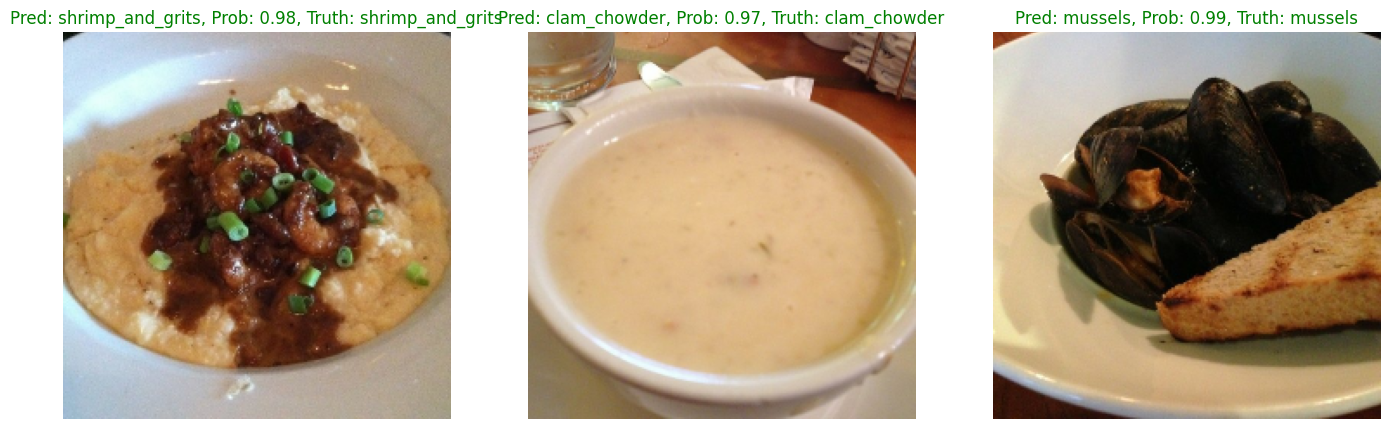

In [116]:
# Make preds on a series of random images
import random
import os

plt.figure(figsize=(17, 10))


for i in range(3):
  class_name = random.choice(class_names)

  file_name  = random.choice(os.listdir(test_dir + "/" + class_name))

  file_path = test_dir + "/" + class_name + "/" + file_name

  # Load

  img = load_and_prep_image(file_path, scale=False)

  # Make prediction
  pred_prob = model.predict(tf.expand_dims(img, axis=0))

  pred_class = class_names[pred_prob.argmax()] # Get highest prediction probability index

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255)

  if class_name == pred_class: # Predict clas matches truth class, make text green
    title_color = "g"
  else: # Predict class doesn't match truth class, make text red
    title_color = "r"

  plt.title(f"Pred: {pred_class}, Prob: {pred_prob.max():.2f}, Truth: {class_name}", c=title_color)

  plt.axis(False)